# API assignment 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from urllib.parse import urlencode

## Settings

In [2]:
site  = "12451000"
start = "2025-12-10"
end   = "2025-12-16"

Path("data").mkdir(exist_ok=True)

## Site metadata

In [3]:
site = "12451000"  # Stehekin River at Stehekin, WA
start = "2025-12-10"
end   = "2025-12-16"

site_url = f"https://waterservices.usgs.gov/nwis/site/?format=rdb&sites={site}"
sites = pd.read_csv(site_url, sep="\t", comment="#", dtype=str)
sites = sites[sites["site_no"].str.fullmatch(r"\d+")].copy()  # remove "15s" row if present
print(sites[["site_no", "station_nm", "dec_lat_va", "dec_long_va", "huc_cd"]])



    site_no                      station_nm   dec_lat_va   dec_long_va  \
1  12451000  STEHEKIN RIVER AT STEHEKIN, WA  48.32958017  -120.6917668   

     huc_cd  
1  17020009  


## Discharge (00060)

In [5]:
url_q = (
    "https://waterservices.usgs.gov/nwis/iv/?format=rdb"
    f"&sites={site}&parameterCd=00060&startDT={start}&endDT={end}"
)

q_df = pd.read_csv(url_q, sep="\t", comment="#")

# Parse datetime without warnings (handles HH:MM and HH:MM:SS)
q_df["datetime"] = q_df["datetime"].astype(str).str.strip()
dt1 = pd.to_datetime(q_df["datetime"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
dt2 = pd.to_datetime(q_df["datetime"], format="%Y-%m-%d %H:%M", errors="coerce")
q_df["datetime"] = dt1.fillna(dt2)
q_df = q_df.dropna(subset=["datetime"]).copy()

# Identify value column + rename
q_valcol = [c for c in q_df.columns
            if c not in ["agency_cd","site_no","datetime","tz_cd"]
            and not c.endswith("_cd")][0]

q_df = q_df.rename(columns={q_valcol: "discharge_cfs"})
q_df["discharge_cfs"] = pd.to_numeric(q_df["discharge_cfs"], errors="coerce")

q_df = (q_df.dropna(subset=["discharge_cfs"])
            .sort_values("datetime")
            .drop_duplicates(["site_no","datetime"]))

# Peak discharge
peak_idx = q_df["discharge_cfs"].idxmax()
print("Peak discharge (cfs):", q_df.loc[peak_idx, "discharge_cfs"])
print("Peak time:", q_df.loc[peak_idx, "datetime"], q_df.loc[peak_idx, "tz_cd"])

q_df.to_csv(f"data/usgs_{site}_iv_discharge_{start}_to_{end}.csv", index=False)
print("Saved:", f"data/usgs_{site}_iv_discharge_{start}_to_{end}.csv")

Peak discharge (cfs): 21500
Peak time: 2025-12-11 05:15:00 PST
Saved: data/usgs_12451000_iv_discharge_2025-12-10_to_2025-12-16.csv


## Stage (00065)

In [6]:
url_h = (
    "https://waterservices.usgs.gov/nwis/iv/?format=rdb"
    f"&sites={site}&parameterCd=00065&startDT={start}&endDT={end}"
)
h_df = pd.read_csv(url_h, sep="\t", comment="#")
h_df["datetime"] = pd.to_datetime(h_df["datetime"], errors="coerce")
h_df = h_df.dropna(subset=["datetime"]).copy()

h_valcol = [c for c in h_df.columns if c not in ["agency_cd","site_no","datetime","tz_cd"] and not c.endswith("_cd")][0]
h_df = h_df.rename(columns={h_valcol: "stage_ft"})
h_df["stage_ft"] = pd.to_numeric(h_df["stage_ft"], errors="coerce")
h_df = h_df.dropna(subset=["stage_ft"]).sort_values("datetime").drop_duplicates(["site_no","datetime"])

h_df.to_csv(f"data/usgs_{site}_iv_stage_{start}_to_{end}.csv", index=False)

/var/folders/5b/_9mgg6750kjdrnvfl2wzxkfr0000gp/T/ipykernel_74513/676224155.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  h_df["datetime"] = pd.to_datetime(h_df["datetime"], errors="coerce")


## Plot

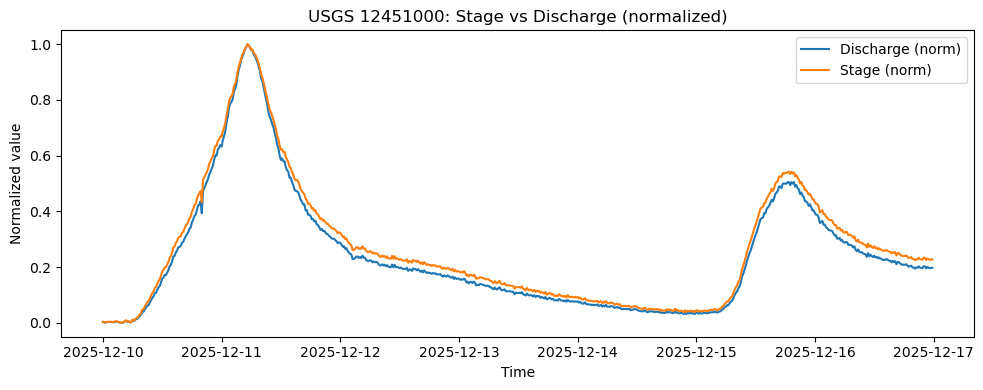

In [6]:
m = q_df.merge(h_df[["datetime","stage_ft"]], on="datetime", how="inner")
m["Q_norm"] = (m["discharge_cfs"] - m["discharge_cfs"].min()) / (m["discharge_cfs"].max() - m["discharge_cfs"].min())
m["H_norm"] = (m["stage_ft"] - m["stage_ft"].min()) / (m["stage_ft"].max() - m["stage_ft"].min())

plt.figure(figsize=(10,4))
plt.plot(m["datetime"], m["Q_norm"], label="Discharge (norm)")
plt.plot(m["datetime"], m["H_norm"], label="Stage (norm)")
plt.legend()
plt.title(f"USGS {site}: Stage vs Discharge (normalized)")
plt.xlabel("Time")
plt.ylabel("Normalized value")
plt.tight_layout()
plt.show()

## NOAA December precipitation data

In [7]:
station = "USC00458059"   # STEHEKIN 4 NW, WA US (network ID is GHCND:USC00458059)
start   = "2025-12-01"
end     = "2025-12-31"

base = "https://www.ncei.noaa.gov/access/services/data/v1"
params = {
    "dataset": "daily-summaries",
    "stations": station,
    "startDate": start,
    "endDate": end,
    "dataTypes": "PRCP",
    "format": "csv",
    "units": "standard",
    "includeStationName": "true",
    "includeStationLocation": "true",
}
url = base + "?" + urlencode(params)

print("Requesting:", url)

prcp = pd.read_csv(url)

print("Rows returned:", len(prcp))
print(prcp.head())

# Clean PRCP
prcp["DATE"] = pd.to_datetime(prcp["DATE"])
prcp["PRCP"] = prcp["PRCP"].replace({"T": 0})     # trace -> 0 (ok for plotting)
prcp["PRCP"] = pd.to_numeric(prcp["PRCP"], errors="coerce")

out_csv = f"data/noaa_{station}_PRCP_{start}_to_{end}.csv"
prcp.to_csv(out_csv, index=False)
print("Saved:", out_csv)


Requesting: https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USC00458059&startDate=2025-12-01&endDate=2025-12-31&dataTypes=PRCP&format=csv&units=standard&includeStationName=true&includeStationLocation=true
Rows returned: 29
       STATION                  NAME  LATITUDE  LONGITUDE  ELEVATION  \
0  USC00458059  STEHEKIN 4 NW, WA US   48.3509  -120.7264      383.1   
1  USC00458059  STEHEKIN 4 NW, WA US   48.3509  -120.7264      383.1   
2  USC00458059  STEHEKIN 4 NW, WA US   48.3509  -120.7264      383.1   
3  USC00458059  STEHEKIN 4 NW, WA US   48.3509  -120.7264      383.1   
4  USC00458059  STEHEKIN 4 NW, WA US   48.3509  -120.7264      383.1   

         DATE  PRCP  
0  2025-12-01  0.00  
1  2025-12-02  0.16  
2  2025-12-03  0.00  
3  2025-12-04  0.06  
4  2025-12-05  0.20  
Saved: data/noaa_USC00458059_PRCP_2025-12-01_to_2025-12-31.csv


## Plot NOAA Precipitation data

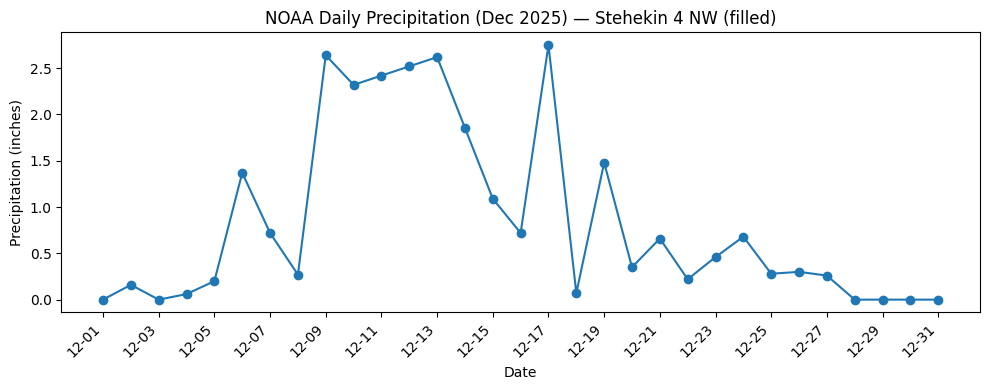

In [8]:
prcp = prcp.sort_values("DATE").copy()

full = pd.date_range(start, end, freq="D")
ts = prcp.set_index("DATE")["PRCP"].reindex(full)
ts_filled = ts.interpolate(limit_direction="both")

plt.figure(figsize=(10,4))
plt.plot(ts_filled.index, ts_filled.values, marker="o")
plt.title("NOAA Daily Precipitation (Dec 2025) — Stehekin 4 NW (filled)")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

